In [5]:
import os
import yaml
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plateconfig import PlateConfig
from scipy.stats import gmean

general_data_dir = "../data"
all_dirs = ["07092025_IF_scan", "07182025_IF_scan"]
config_dict = {}
if_data_file = "Cell.csv"

for data_dir in all_dirs:
	config_fname = f"{general_data_dir}/{data_dir}/plate_config.yaml"
	if os.path.exists(config_fname):
		plate_obj = PlateConfig(config_fname)
		config_dict[data_dir] = plate_obj
	else:
		print(f"Config file does not exist.")


Successfully loaded ../data/07092025_IF_scan/plate_config.yaml
Successfully loaded ../data/07182025_IF_scan/plate_config.yaml


In [6]:
dfs = []
for dir in all_dirs:
	full_fname = f"{general_data_dir}/{dir}/{if_data_file}"
	columns = ["WellId", "CircTotalIntenCh2", "CircTotalIntenCh3"]
	df = pd.read_csv(full_fname, usecols=columns)
	df["WellId"] = [x.strip() for x in df["WellId"]] # remove leading/trailing spaces in WellIds

	# get the corresponding configuration dictionary
	plate_config = config_dict[dir]
	plate_config.rows = plate_config.row_to_patient.keys()
 
	columns = list(plate_config.column_to_stain.keys())
	# Combine control wells (i.e., B1 and B2) into a single WellId
	if plate_config.double_control_wells:
		control_column_tuples = [(1,2),(7,8)]
		control_well_dict = {}
		for tup in control_column_tuples:
			for row in plate_config.row_to_patient.keys():
				well_id1 = f"{row}{tup[0]:02d}"
				well_id2 = f"{row}{tup[1]:02d}"
				df = df.replace(well_id2, well_id1)
		columns.remove(2)
		columns.remove(8)
	plate_config.control_columns = [1, 7]
	plate_config.test_columns = [np.r_[3:7], np.r_[9:13]]
	plate_config.columns = columns
 
	# store row and columns for each well id as individual columns
	df["Row"] = [x[0] for x in df["WellId"]]
	df["Column"] = [x[1:] for x in df["WellId"]]
	plate_config.set_plate_data(df)
	display(df)

,WellId,CircTotalIntenCh2,CircTotalIntenCh3,Row,Column
0,B01,982568,542595,B,01
1,B01,398514,306604,B,01
2,B01,415494,305690,B,01
3,B01,552306,394098,B,01
4,B01,438689,346265,B,01
...,...,...,...,...,...
48708,D12,1964325,1076597,D,12
48709,D12,2871097,2397871,D,12
48710,D12,2543619,2666148,D,12
48711,D12,2989895,2074228,D,12


,WellId,CircTotalIntenCh2,CircTotalIntenCh3,Row,Column
0,B01,1928539,644046,B,01
1,B01,1344189,376605,B,01
2,B01,1626749,357199,B,01
3,B01,2920563,953703,B,01
4,B01,2137419,1189482,B,01
...,...,...,...,...,...
58918,E12,662498,180994,E,12
58919,E12,1755947,319289,E,12
58920,E12,2167799,387586,E,12
58921,E12,1840855,279931,E,12


In [14]:
def calc_l2fc(plate, lfc_df):
	stat1_lfcs = []
	stat3_lfcs = []
	for row in lfc_df["Row"].unique():
		cur_df = lfc_df[lfc_df["Row"] == row]
		for i, control_col in enumerate(plate.control_columns):
			control_data = cur_df[cur_df["Column"] == control_col]
			test_cols = cur_df[cur_df["Column"].isin([control_col, *plate.test_columns[i]])]
			#print(control_data)
			#print(cur_df["STAT1 log2 Median"])
			#print(control_data["STAT1 log2 Median"].values[0])
			new_stat1_l2fcs  = test_cols["STAT1 log2 Median"] - control_data["STAT1 log2 Median"].values[0]
			new_stat3_l2fcs  = test_cols["STAT3 log2 Median"] - control_data["STAT3 log2 Median"].values[0]
			#print(row, control_col, new_stat1_l2fcs)
			stat1_lfcs = stat1_lfcs + list(new_stat1_l2fcs)
			stat3_lfcs = stat3_lfcs + list(new_stat3_l2fcs)
			#print(stat1_lfcs)
			#return;
	lfc_df["STAT1 LFC"] = stat1_lfcs
	lfc_df["STAT3 LFC"] = stat3_lfcs
	return lfc_df
			

def find_pct_max(data):
	stat1_means = data.groupby("WellId")["CircTotalIntenCh2"].apply(gmean)
	stat1_pcts = stat1_means.div(stat1_means.max())
	stat3_means = data.groupby("WellId")["CircTotalIntenCh3"].apply(gmean)
	stat3_pcts = stat3_means.div(stat3_means.max())
	return stat1_pcts, stat3_pcts


for dir in all_dirs:
	plate = config_dict[dir]
	data = plate.data
	raw_dfs = []
	pct_max_dfs = []
	for row in data["Row"].unique():
		for i, control_col in enumerate(plate.control_columns):
			select_cols = [control_col, *plate.test_columns[i]]
			formatted_select_cols = [f"{x:02d}" for x in select_cols]
			select_data = data[(data["Row"] == row) & (data["Column"].isin(formatted_select_cols))].copy()
			raw_dfs.append(select_data)

			stat1, stat3 = find_pct_max(select_data)
			pct_max_df = pd.DataFrame()
			pct_max_df["STAT1"] = stat1
			pct_max_df["STAT3"] = stat3
			
			pct_max_dfs.append(pct_max_df)
	
	pct_df = pd.concat(pct_max_dfs)

	rows = [x.strip()[0] for x in pct_df.index.values]
	cols = [int(x.strip()[1:]) for x in pct_df.index.values]
	pct_df["Row"] = rows
	pct_df["Column"] = cols
	pct_df["STAT"] = [plate.column_to_stain[int(x)] for x in cols]
	pct_df["Donor"] = [plate.row_to_patient[x] for x in rows]
	pct_df["IL-6 Concentration"] = ["10 ng/mL" for x in cols]
	pct_df["Time"] = [plate.column_to_t_pts[int(x)] for x in cols]
	pct_df["Replicate"] = [plate.row_to_replicate[x] for x in rows]
	plate.pct_df = pct_df
	
	processed_lfc_df = calc_l2fc(plate, stat_lfc_df)
	plate.lfc_df = processed_lfc_df   
	raw_df = pd.concat(raw_dfs, ignore_index=True)
	# Create the log2 fold change dataframe
	stat1_lfc_med = raw_df.groupby("WellId")["CircTotalIntenCh2"].median().apply(np.log2)
	stat1_lfc_std = raw_df.groupby("WellId")["CircTotalIntenCh2"].std().apply(np.log2)
	stat3_lfc_med = raw_df.groupby("WellId")["CircTotalIntenCh3"].median().apply(np.log2)
	stat3_lfc_std = raw_df.groupby("WellId")["CircTotalIntenCh3"].std().apply(np.log2)
 
	stat_lfc_df = pd.concat([stat1_lfc_med, stat1_lfc_std, stat3_lfc_med, stat3_lfc_std], axis=1)
	stat_lfc_df.columns = ["STAT1 log2 Median", "STAT1 log2 STD", "STAT3 log2 Median", "STAT3 log2 STD"]
	rows = [x.strip()[0] for x in stat_lfc_df.index.values]
	cols = [int(x.strip()[1:]) for x in stat_lfc_df.index.values]
	stat_lfc_df["Row"] = rows
	stat_lfc_df["Column"] = cols
	stat_lfc_df["STAT"] = [plate.column_to_stain[int(x)] for x in cols]
	stat_lfc_df["Donor"] = [plate.row_to_patient[x] for x in rows]
	stat_lfc_df["IL-6 Concentration"] = ["10 ng/mL" for x in cols]
	stat_lfc_df["Time"] = [plate.column_to_t_pts[int(x)] for x in cols]
	stat_lfc_df["Replicate"] = [plate.row_to_replicate[x] for x in rows]
	#display(stat_lfc_df)
	
	processed_lfc_df = calc_l2fc(plate, stat_lfc_df)
	plate.lfc_df = processed_lfc_df

## Plot log fold change

/tmp/ipykernel_5614/4254286776.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  stat1_ax.legend(title="Replicate")
/tmp/ipykernel_5614/4254286776.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  stat3_ax.legend(title="Replicate")
/tmp/ipykernel_5614/4254286776.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  stat1_ax.legend(title="Replicate")
/tmp/ipykernel_5614/4254286776.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  stat3_ax.legend(title="Replicate")


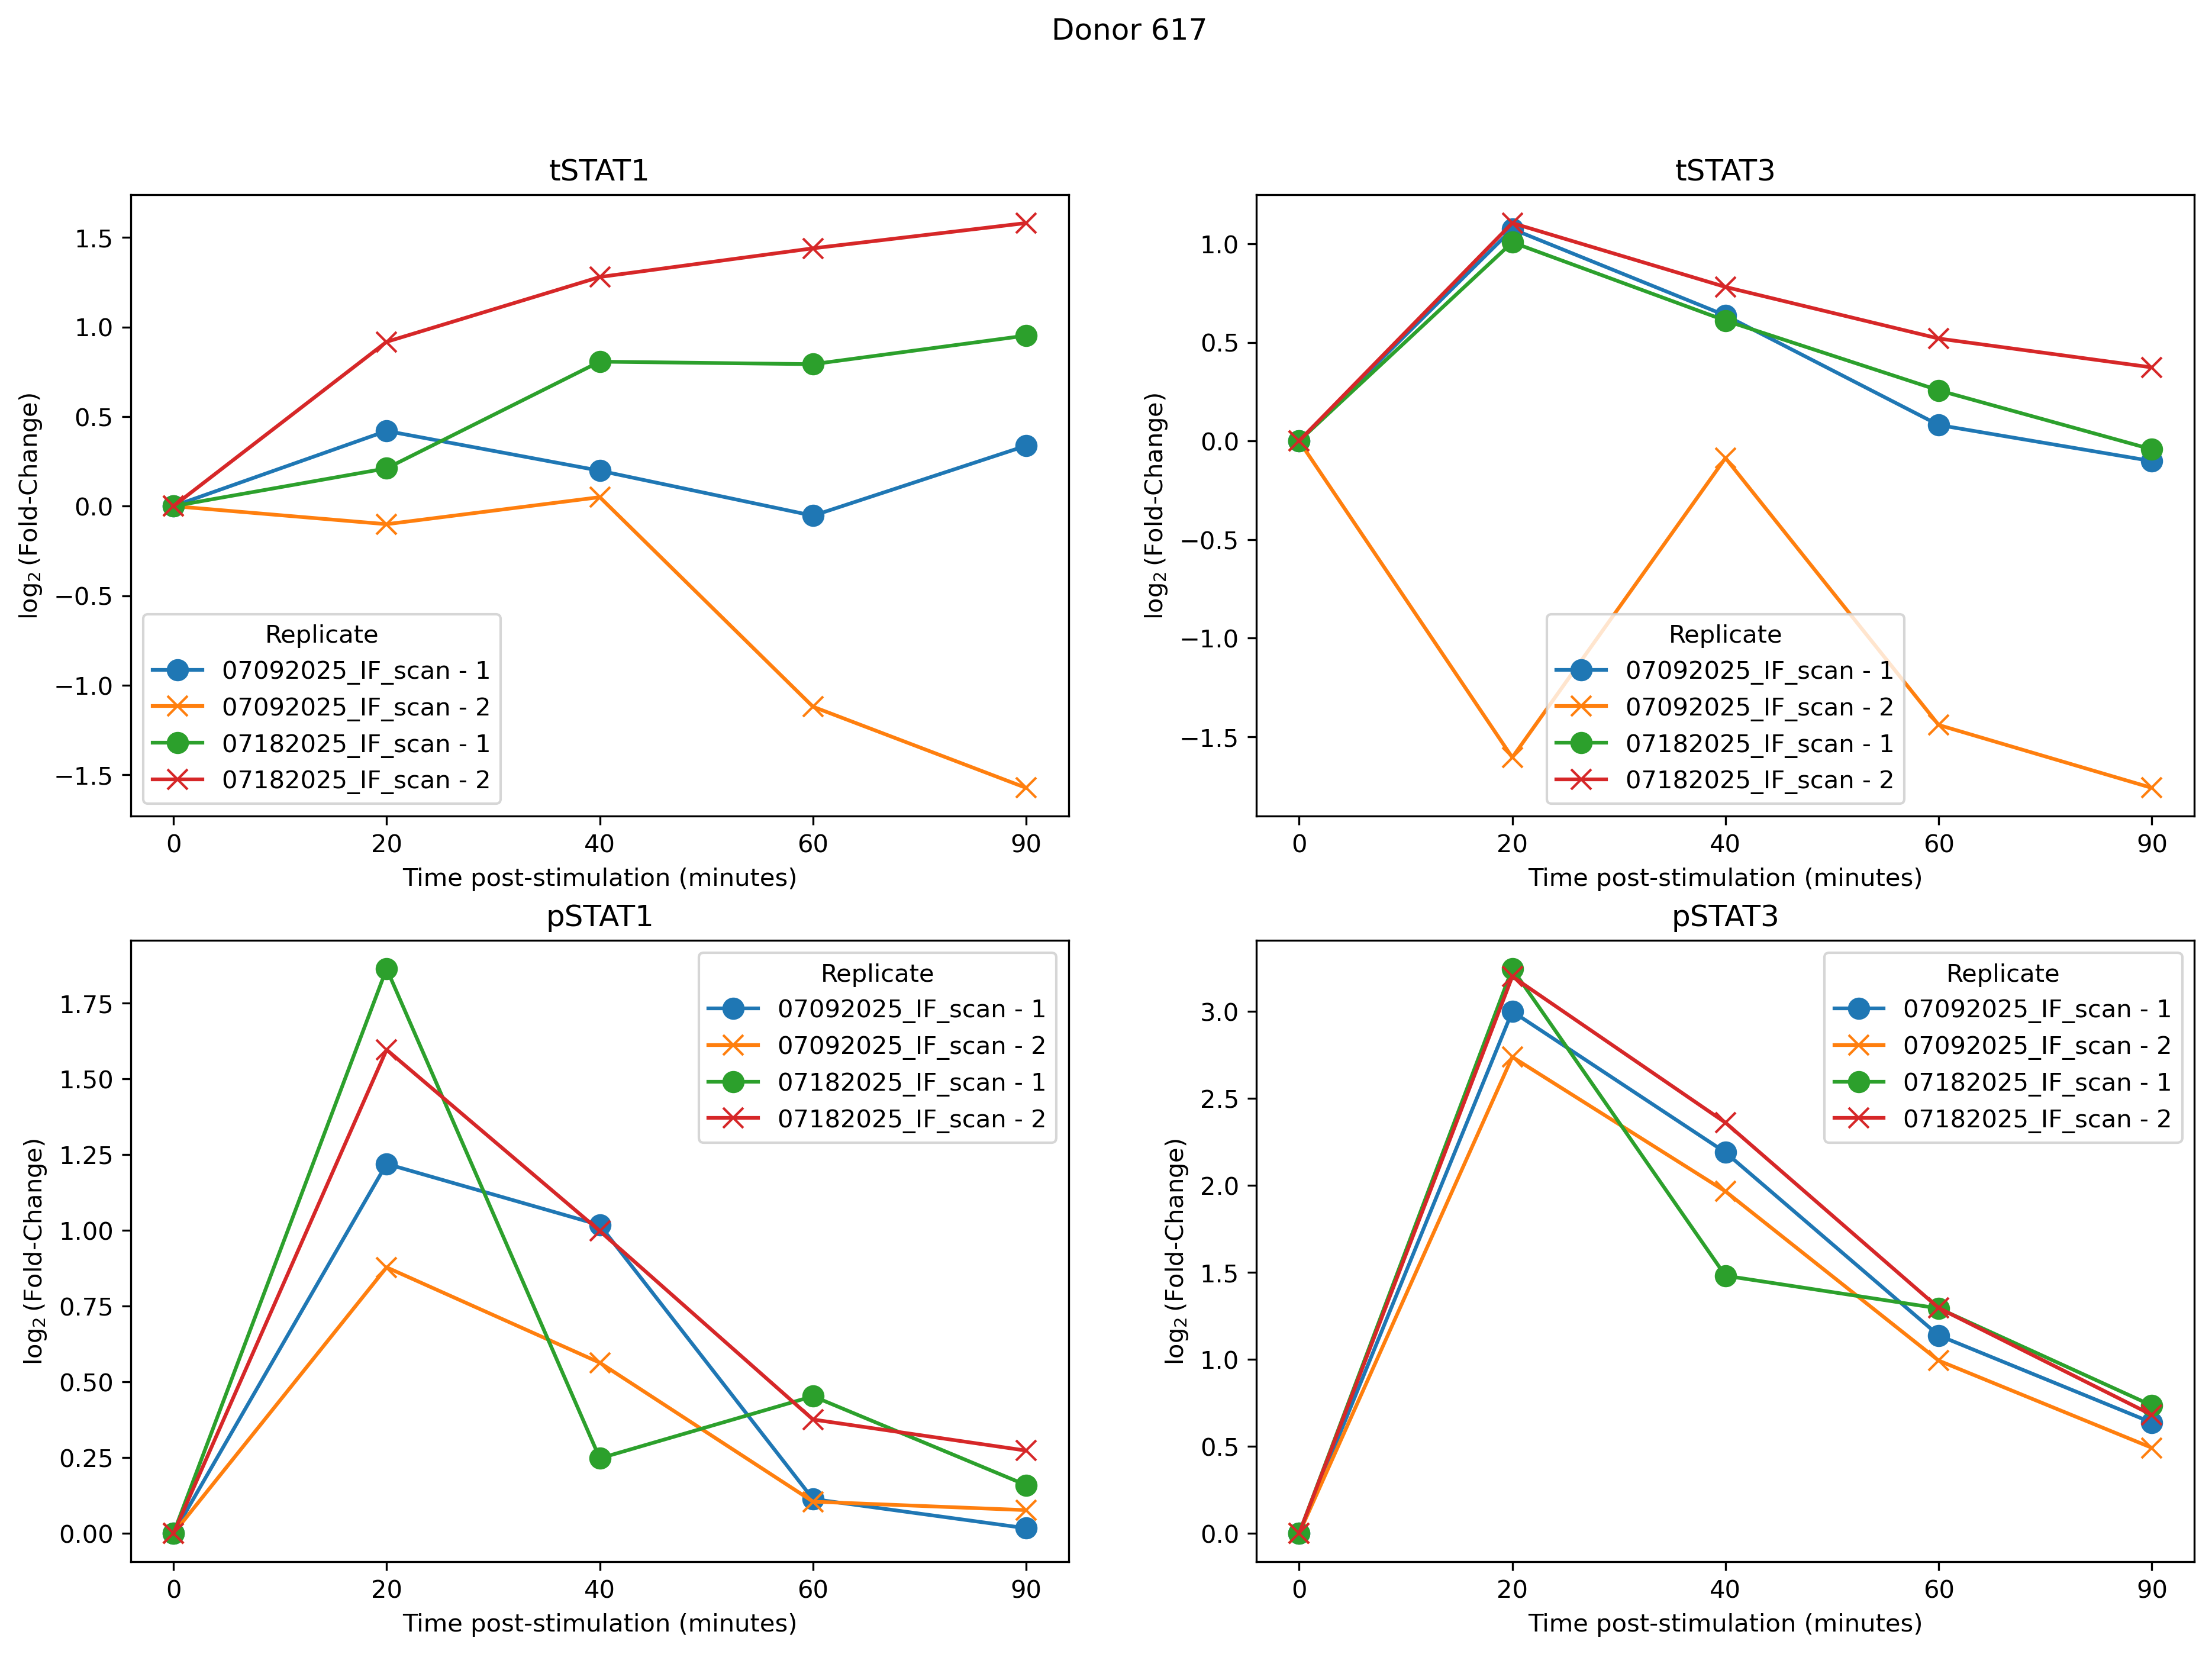

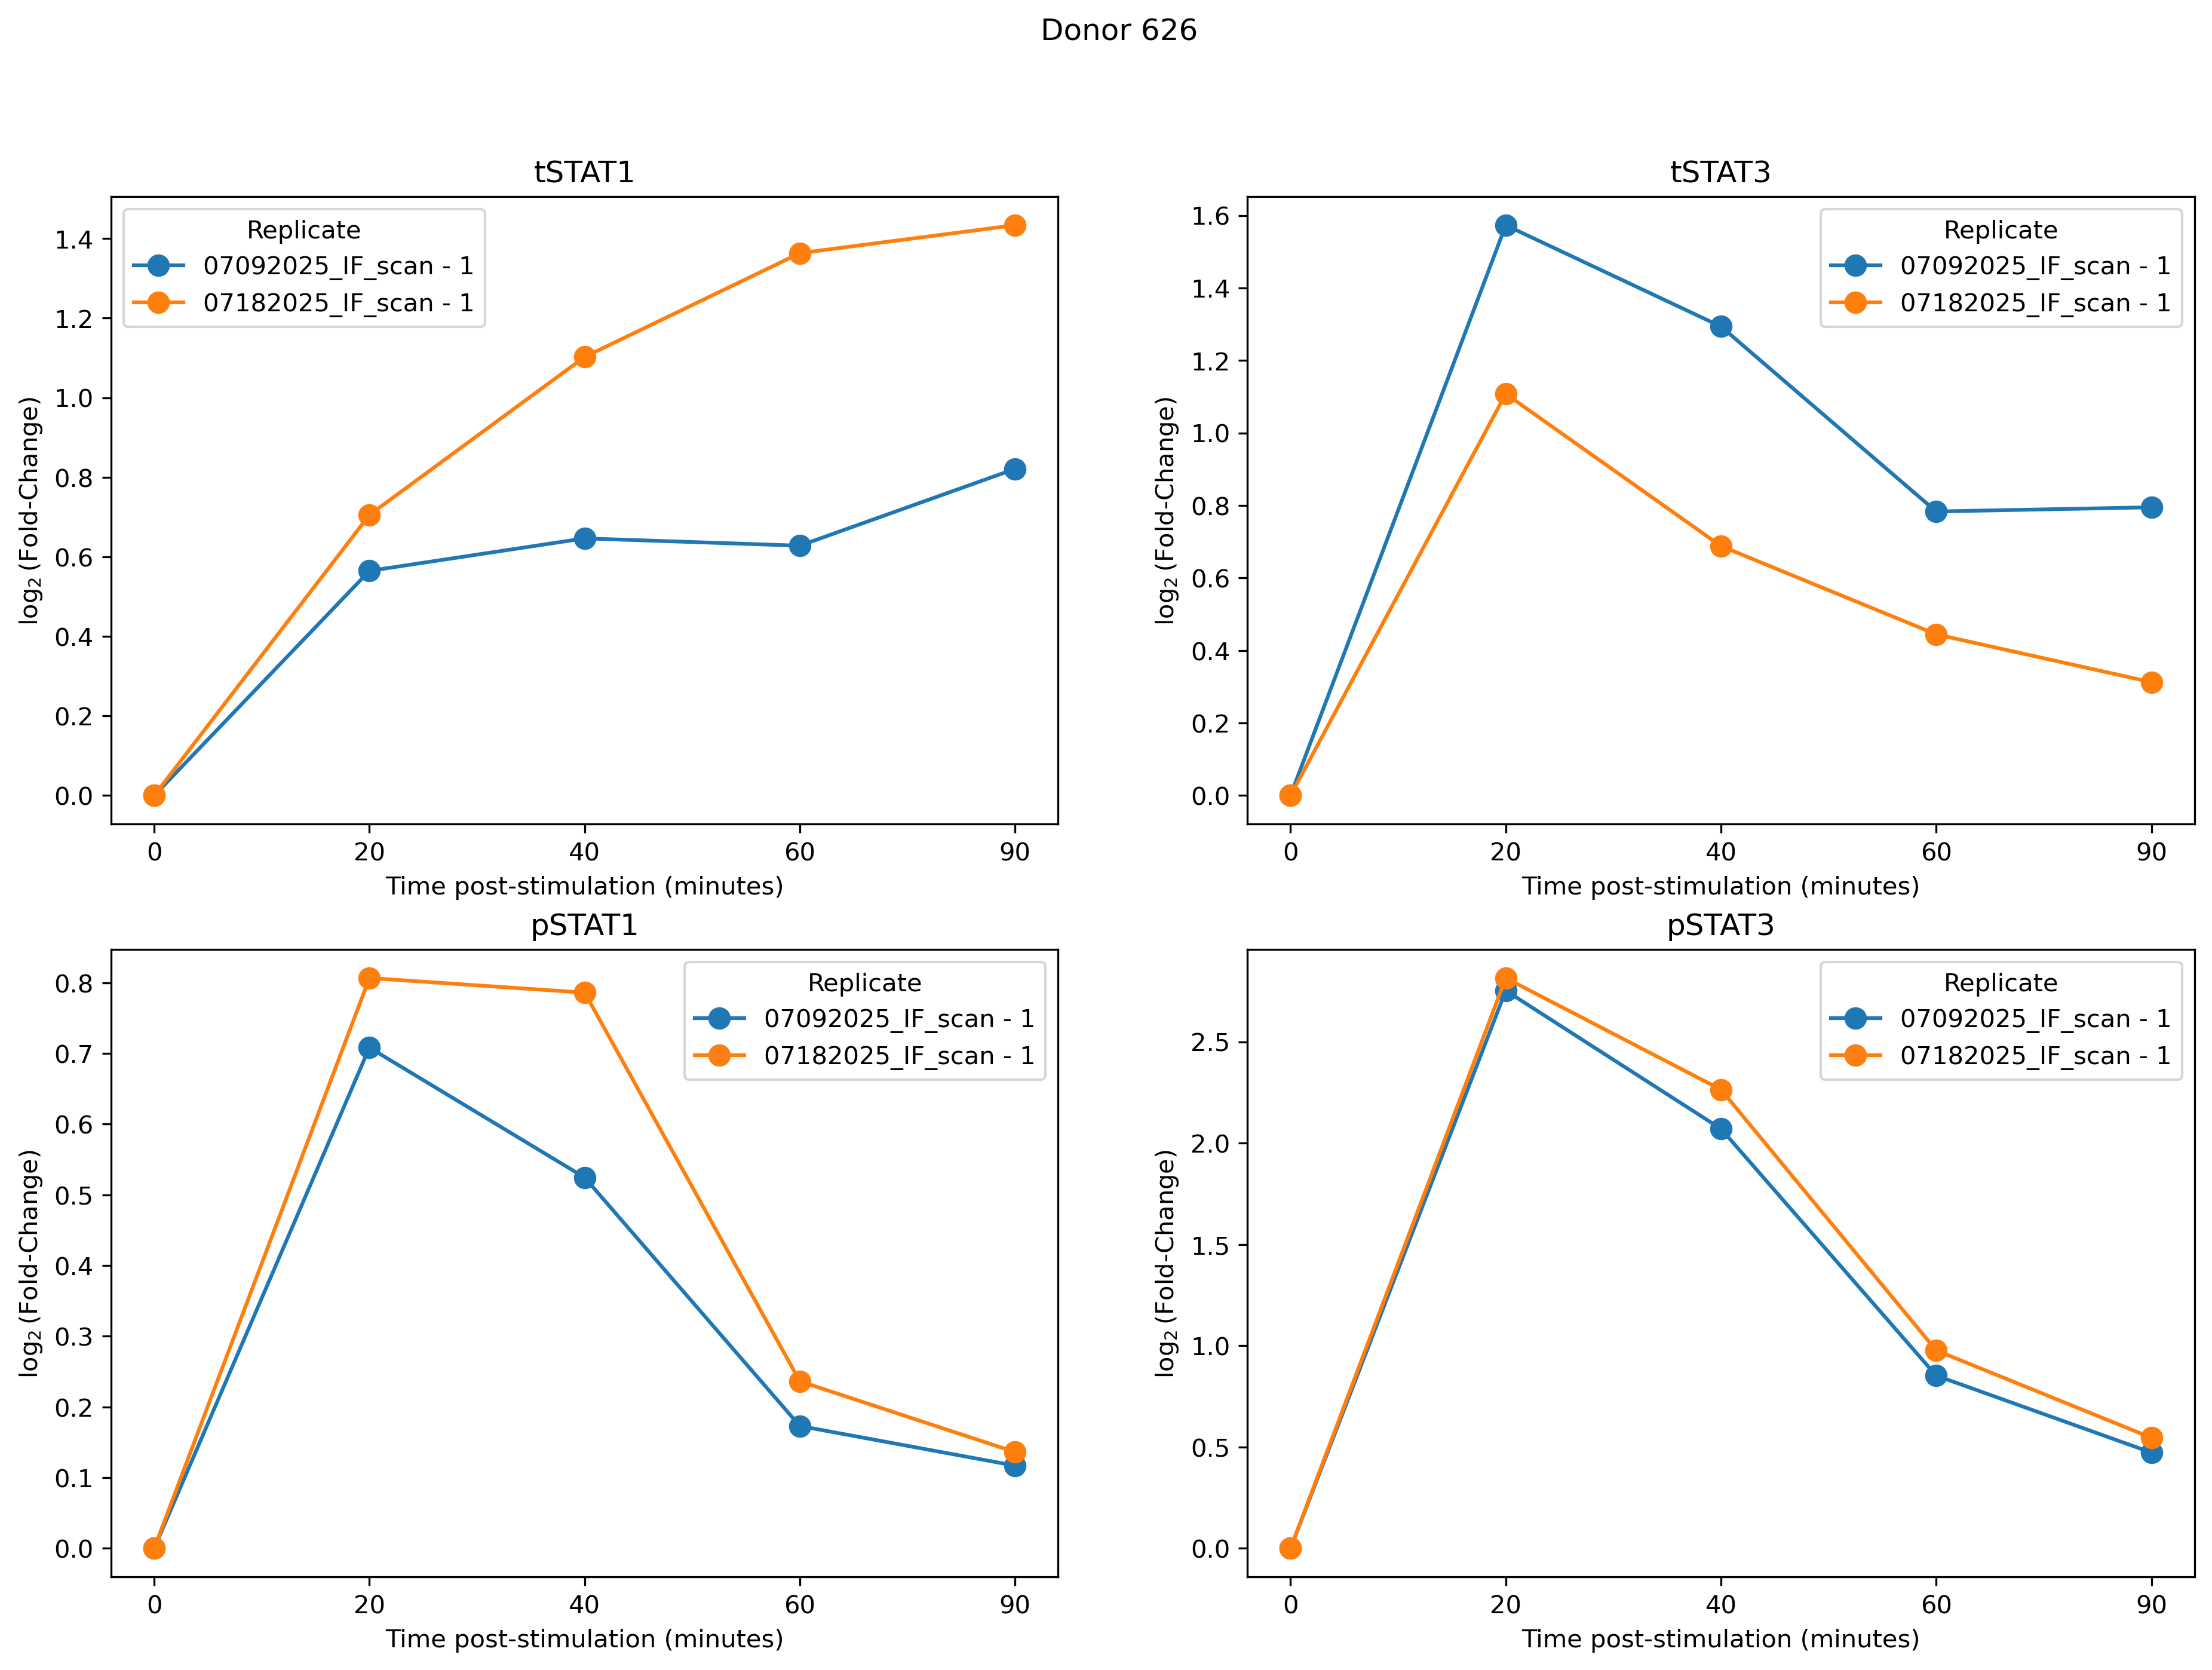

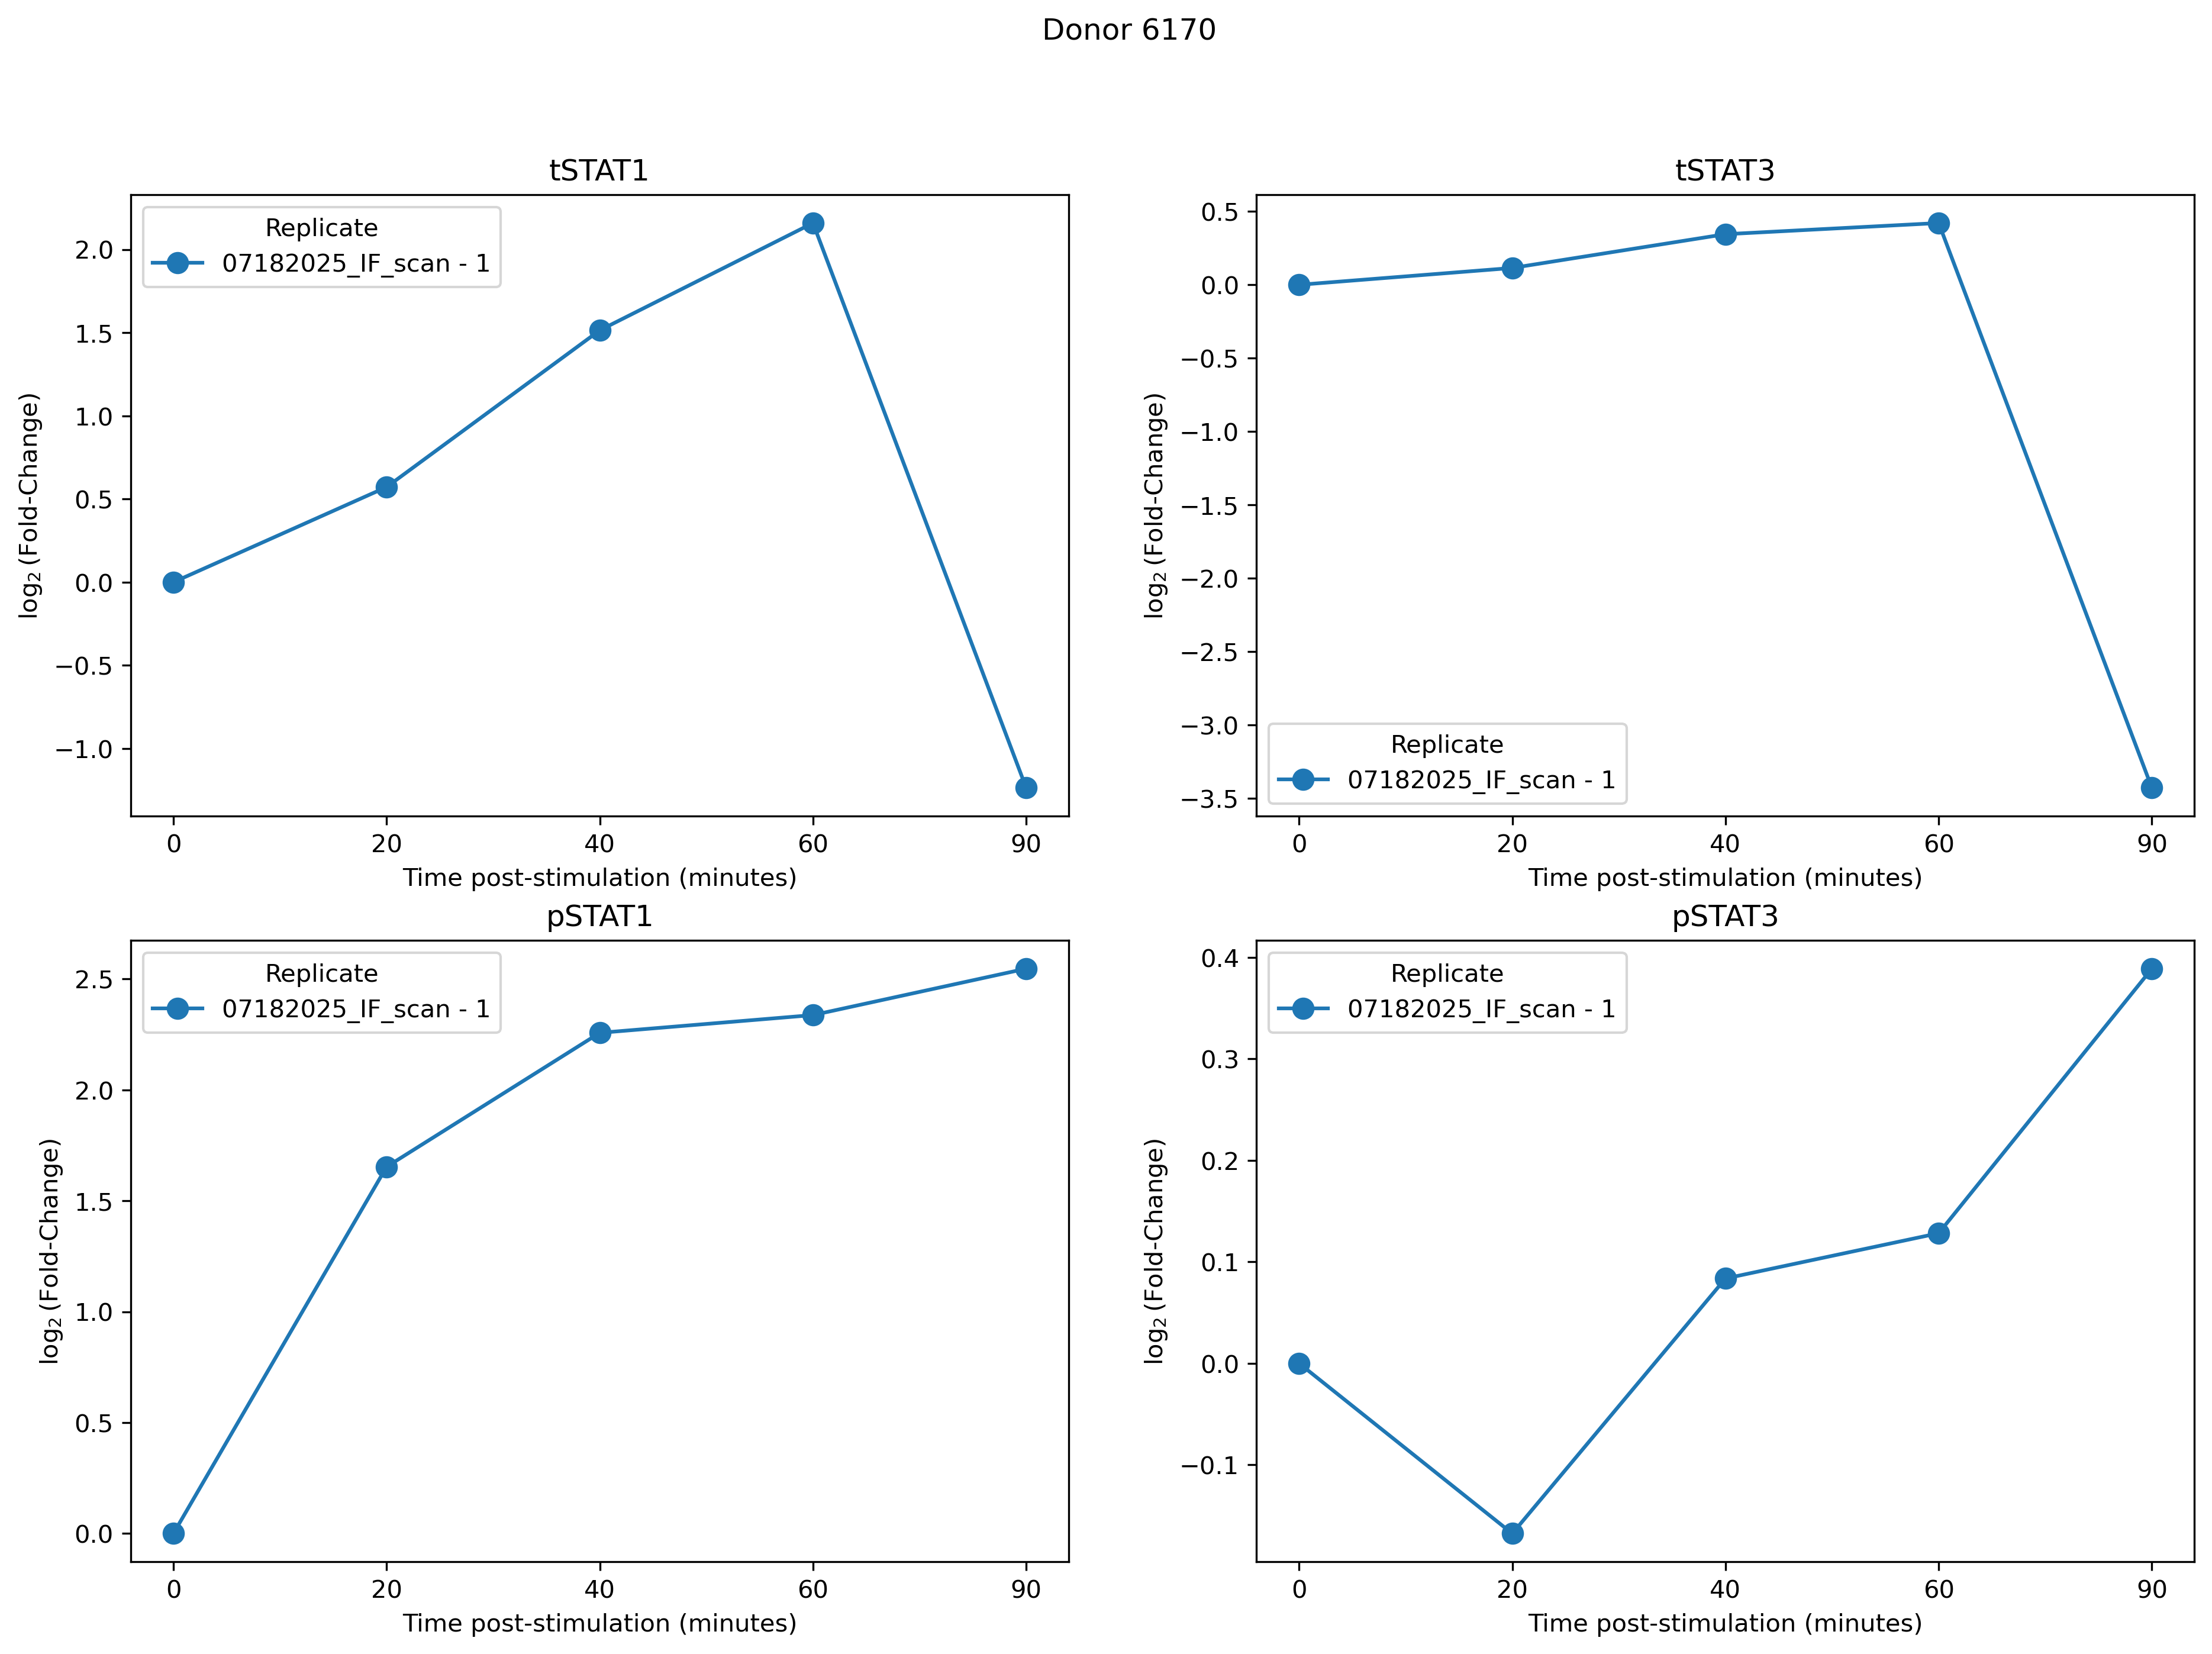

In [19]:
compile_ids = []
for dirs in all_dirs:
	dir_ids = config_dict[dir].get_unique_patient_ids()
	for id in dir_ids:
		compile_ids.append(id)

all_ids = np.unique(compile_ids)

id_to_fig = dict([id, plt.subplots(2,2, figsize=(15,10), dpi=300)] for id in all_ids);
ms = 8 # markersize

for id in all_ids:
	fig, ax = id_to_fig[id]
	fig.suptitle(f"Donor {id}")
	for dir in all_dirs:
		plate = config_dict[dir]
		
		# Get tSTAT data first 
		df = plate.lfc_df[(plate.lfc_df["Donor"] == id) & (plate.lfc_df["STAT"] == "tSTAT")] # TO DO: add case where included plate does NOT include specific donor
		
		stat1_ax = ax[0][0]
		stat3_ax = ax[0][1]
		for rep in df["Replicate"].unique():
			select_df = df.loc[df["Replicate"]== rep]
			stat1_ax.errorbar(x=select_df["Time"], y=select_df["STAT1 LFC"], #yerr=select_df["STAT1 log2 STD"],
						marker=plate.replicate_to_marker[rep], ms=ms,
						ls="-", label=f"{dir} - {rep}", capsize=2)
			
			stat3_ax.errorbar(x=select_df["Time"], y=select_df["STAT3 LFC"], #yerr=select_df["STAT3 log2 STD"],
						marker=plate.replicate_to_marker[rep], ms=ms,
						ls="-", label=f"{dir} - {rep}", capsize=2)
		stat1_ax.set_ylabel("$\log_2$(Fold-Change)")
		stat1_ax.set_xlabel("Time post-stimulation (minutes)")
		stat1_ax.legend(title="Replicate")
		stat1_ax.set_title("tSTAT1")
		stat3_ax.set_ylabel("$\log_2$(Fold-Change)")
		stat3_ax.set_xlabel("Time post-stimulation (minutes)")
		stat3_ax.legend(title="Replicate")
		stat3_ax.set_title("tSTAT3")
  
		# Get pSTAT data first 
		df = plate.lfc_df[(plate.lfc_df["Donor"] == id) & (plate.lfc_df["STAT"] == "pSTAT")] # TO DO: add case where included plate does NOT include specific donor
		
		stat1_ax = ax[1][0]
		stat3_ax = ax[1][1]
		for rep in df["Replicate"].unique():
			select_df = df.loc[df["Replicate"]== rep]
			stat1_ax.errorbar(x=select_df["Time"], y=select_df["STAT1 LFC"], #yerr=select_df["STAT1 log2 STD"],
						marker=plate.replicate_to_marker[rep], ms=ms,
						ls="-", label=f"{dir} - {rep}", capsize=2)
			
			stat3_ax.errorbar(x=select_df["Time"], y=select_df["STAT3 LFC"], #yerr=select_df["STAT3 log2 STD"],
						marker=plate.replicate_to_marker[rep], ms=ms,
						ls="-", label=f"{dir} - {rep}", capsize=2)
		stat1_ax.set_ylabel("$\log_2$(Fold-Change)")
		stat1_ax.set_xlabel("Time post-stimulation (minutes)")
		stat1_ax.legend(title="Replicate")
		stat1_ax.set_title("pSTAT1")
		stat3_ax.set_ylabel("$\log_2$(Fold-Change)")
		stat3_ax.set_xlabel("Time post-stimulation (minutes)")
		stat3_ax.legend(title="Replicate")
		stat3_ax.set_title("pSTAT3")

### Plot % Max

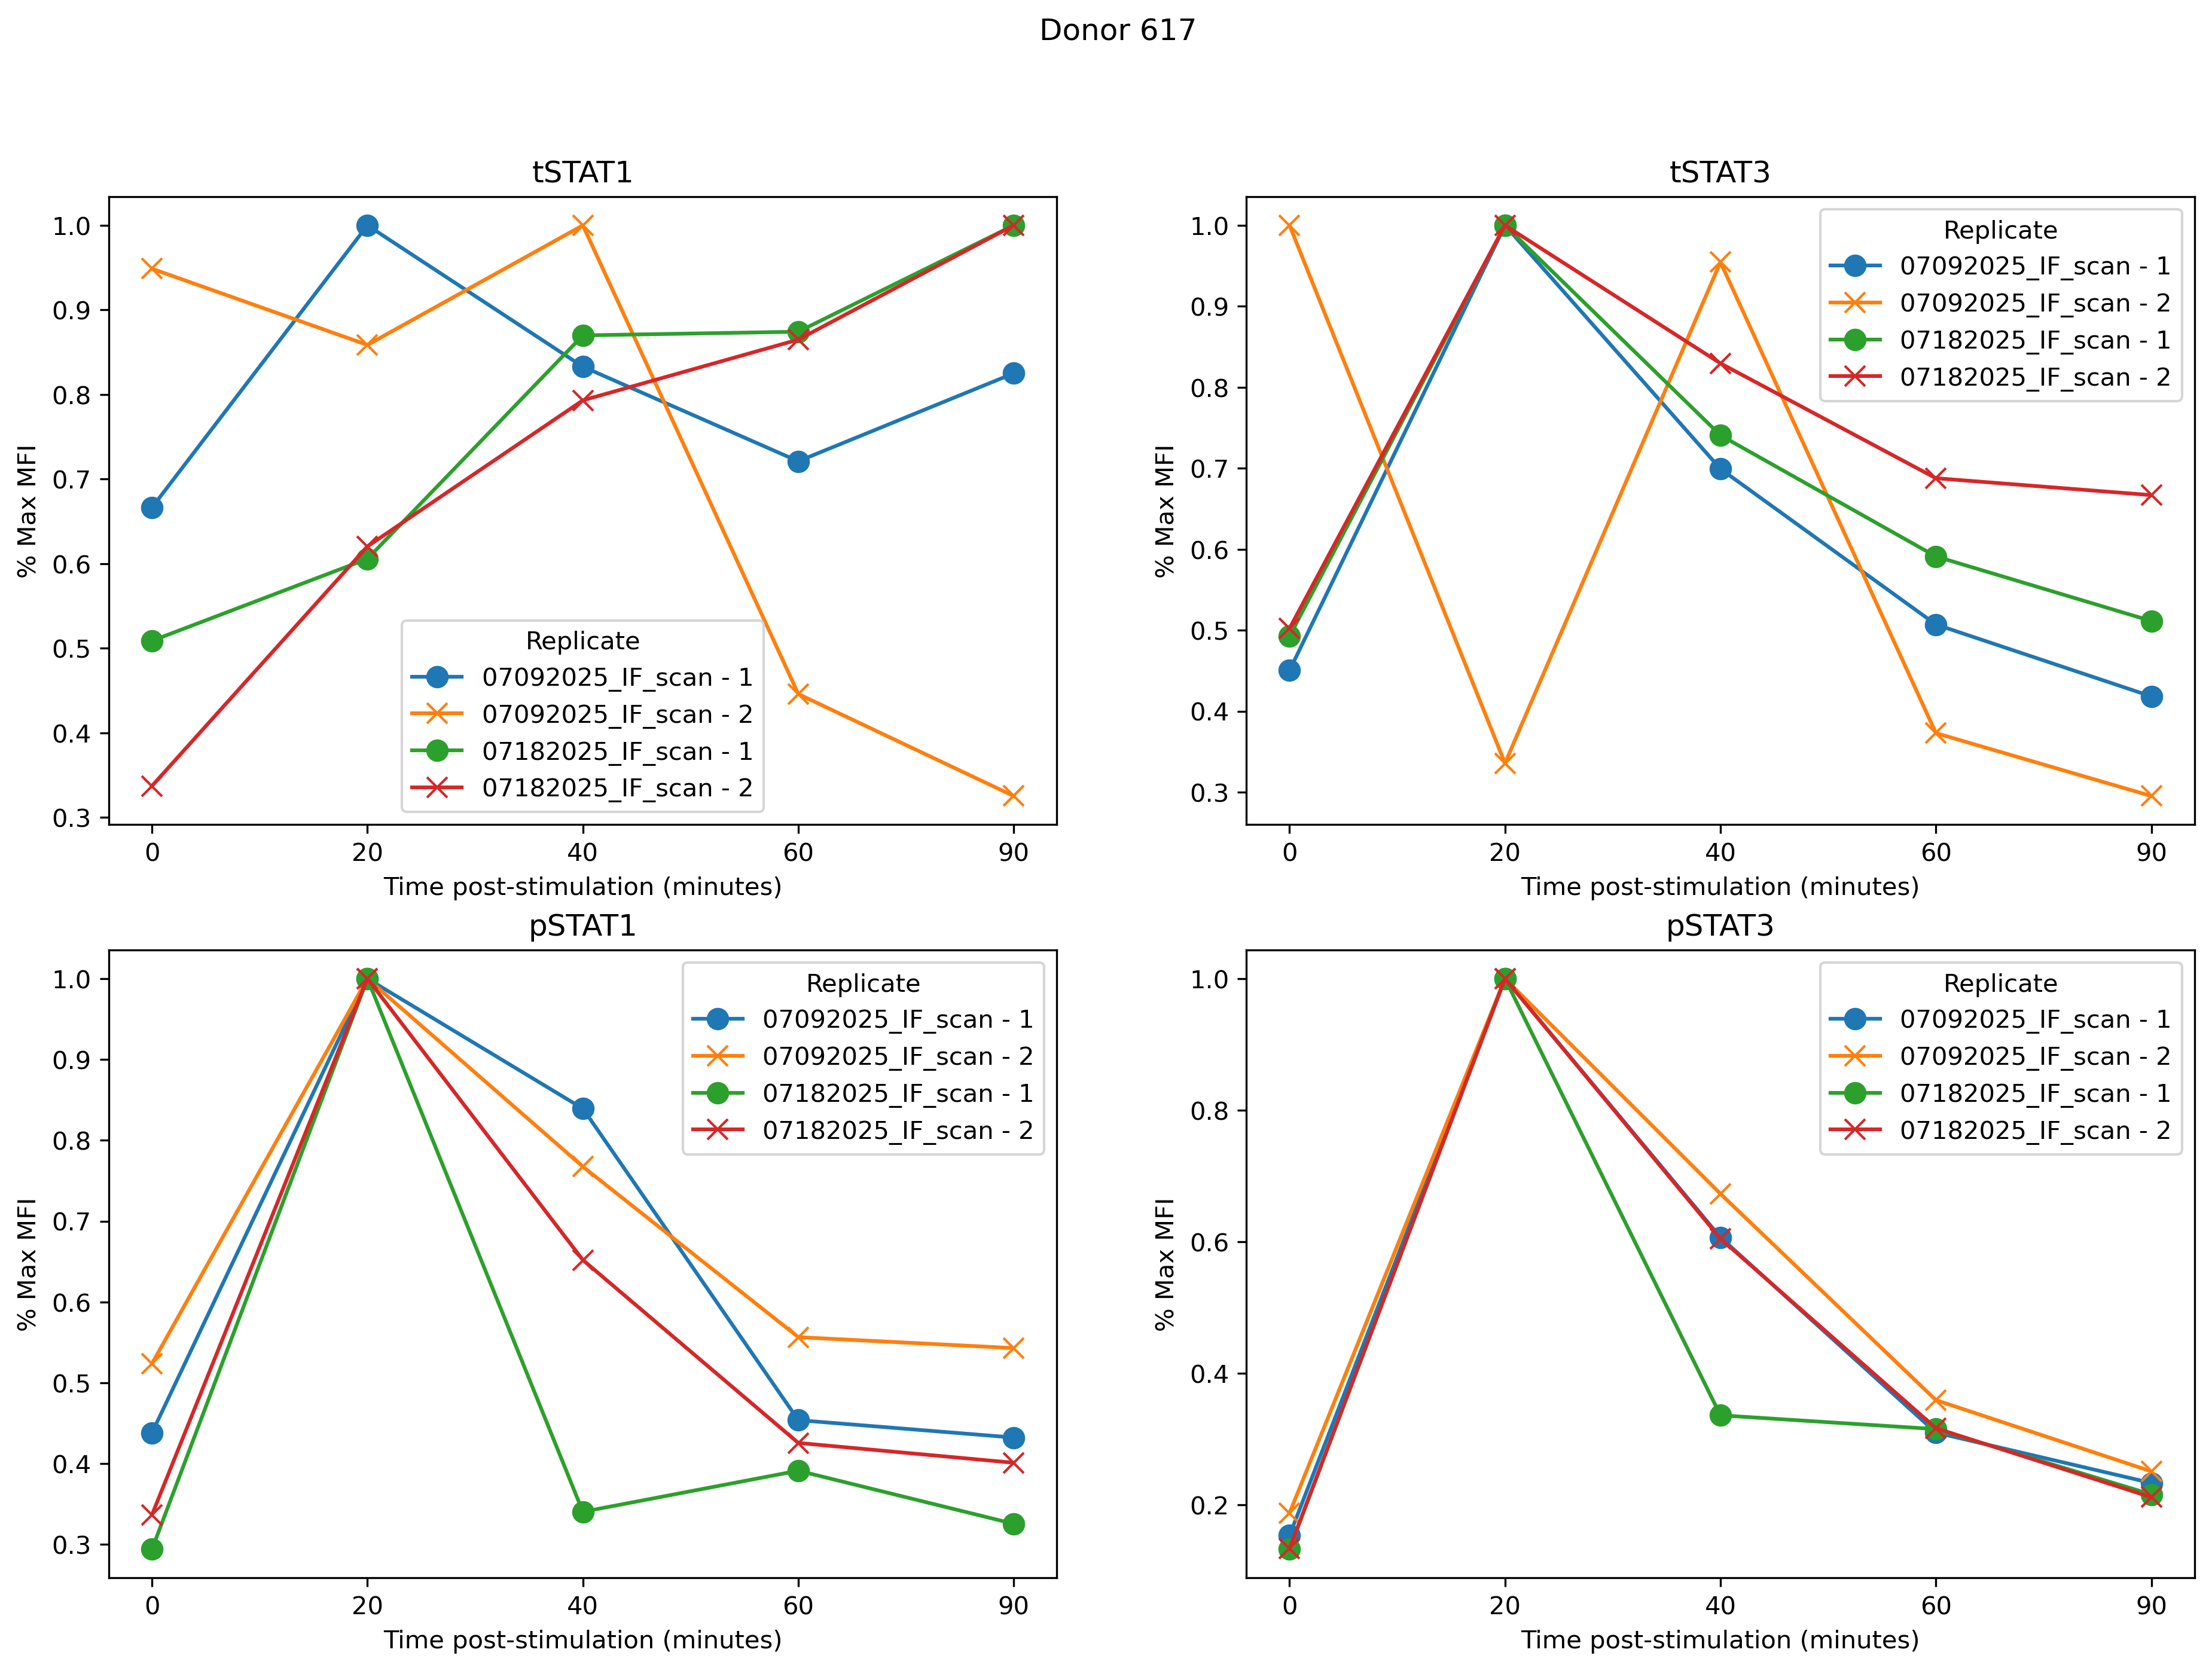

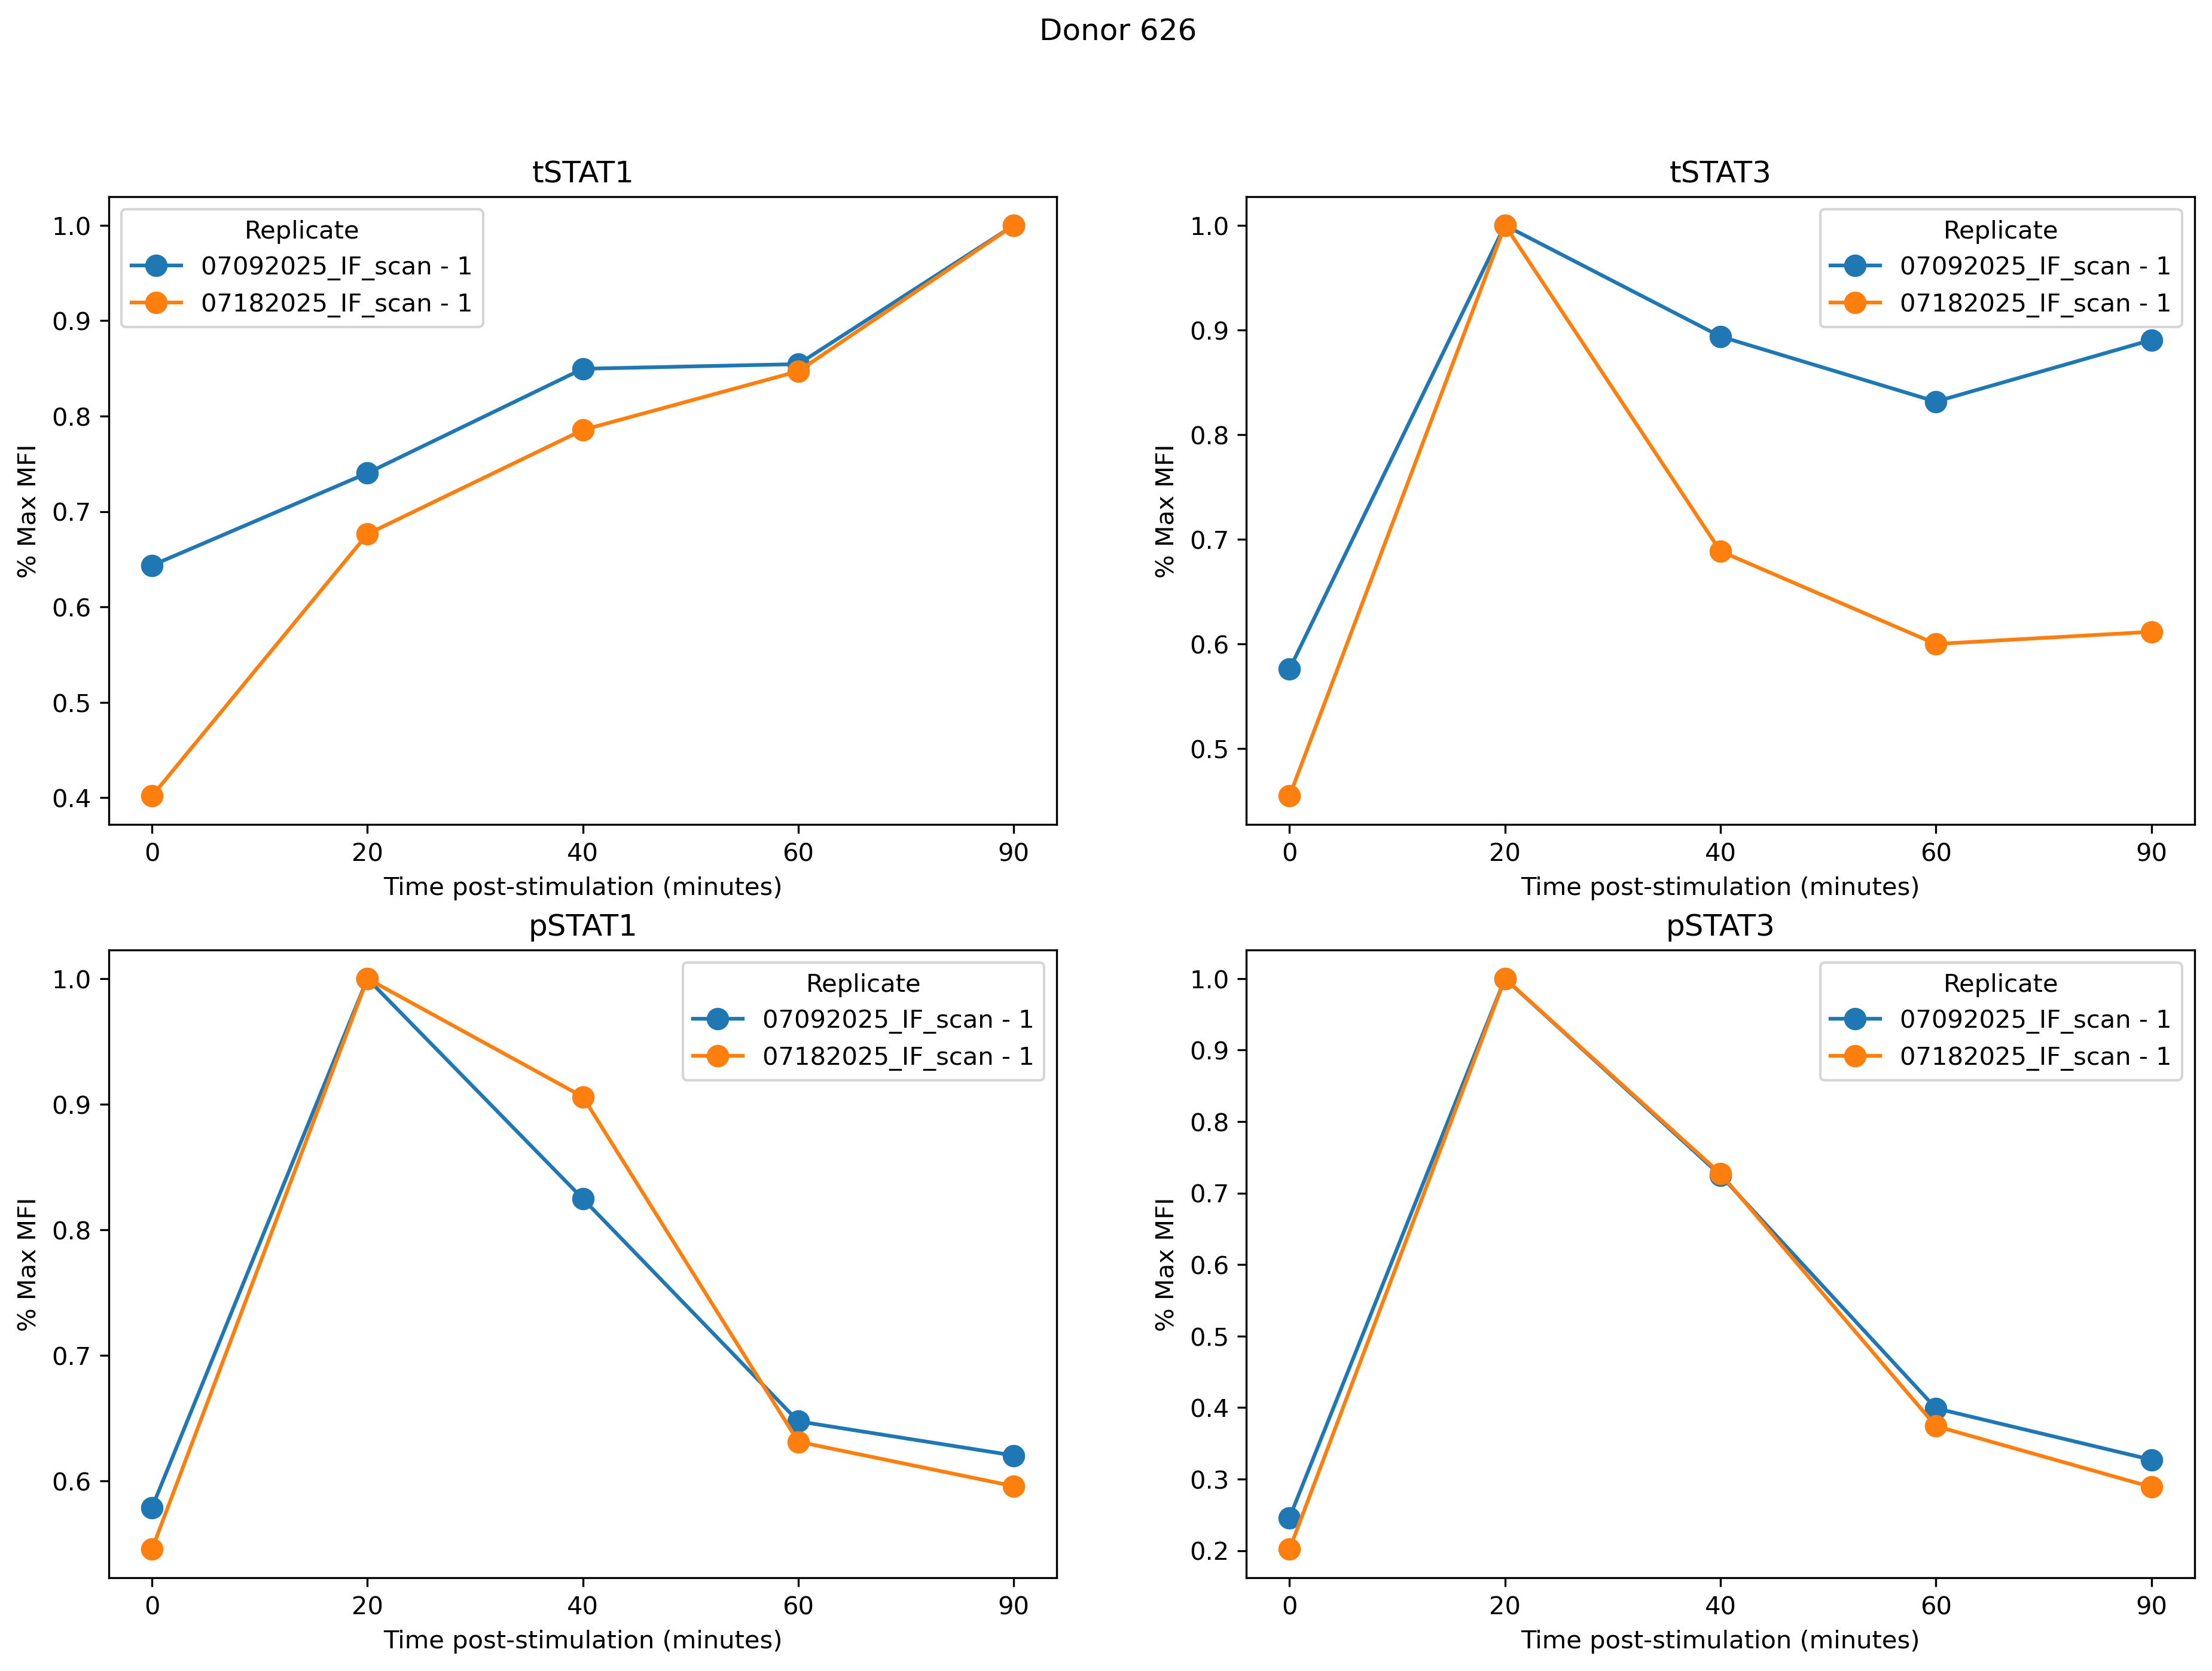

In [18]:
compile_ids = []
for dirs in all_dirs:
	dir_ids = config_dict[dir].get_unique_patient_ids()
	for id in dir_ids:
		compile_ids.append(id)
all_ids = np.unique(compile_ids)

id_to_fig = dict([id, plt.subplots(2,2, figsize=(15,10), dpi=300)] for id in all_ids);
ms = 8 # markersize

for id in all_ids:
	fig, ax = id_to_fig[id]
	fig.suptitle(f"Donor {id}")
	for dir in all_dirs:
		plate = config_dict[dir]
		
		# Get tSTAT data first 
		df = plate.pct_df[(plate.pct_df["Donor"] == id) & (plate.pct_df["STAT"] == "tSTAT")] # TO DO: add case where included plate does NOT include specific donor
		
		stat1_ax = ax[0][0]
		stat3_ax = ax[0][1]
		for rep in df["Replicate"].unique():
			select_df = df.loc[df["Replicate"]== rep]
			stat1_ax.plot(select_df["Time"], select_df["STAT1"],
						marker=plate.replicate_to_marker[rep], ms=ms,
						ls="-", label=f"{dir} - {rep}")
			
			stat3_ax.plot(select_df["Time"], select_df["STAT3"],
						marker=plate.replicate_to_marker[rep], ms=ms,
						ls="-", label=f"{dir} - {rep}")
		stat1_ax.set_ylabel("% Max MFI")
		stat1_ax.set_xlabel("Time post-stimulation (minutes)")
		stat1_ax.legend(title="Replicate")
		stat1_ax.set_title("tSTAT1")
		stat3_ax.set_ylabel("% Max MFI")
		stat3_ax.set_xlabel("Time post-stimulation (minutes)")
		stat3_ax.legend(title="Replicate")
		stat3_ax.set_title("tSTAT3")
  
		# Get pSTAT data first 
		df = plate.pct_df[(plate.pct_df["Donor"] == id) & (plate.pct_df["STAT"] == "pSTAT")] # TO DO: add case where included plate does NOT include specific donor
		
		stat1_ax = ax[1][0]
		stat3_ax = ax[1][1]
		for rep in df["Replicate"].unique():
			select_df = df.loc[df["Replicate"]== rep]
			stat1_ax.plot(select_df["Time"], select_df["STAT1"],
						marker=plate.replicate_to_marker[rep], ms=ms,
						ls="-", label=f"{dir} - {rep}")
			
			stat3_ax.plot(select_df["Time"], select_df["STAT3"],
						marker=plate.replicate_to_marker[rep], ms=ms,
						ls="-", label=f"{dir} - {rep}")
		stat1_ax.set_ylabel("% Max MFI")
		stat1_ax.set_xlabel("Time post-stimulation (minutes)")
		stat1_ax.legend(title="Replicate")
		stat1_ax.set_title("pSTAT1")
		stat3_ax.set_ylabel("% Max MFI")
		stat3_ax.set_xlabel("Time post-stimulation (minutes)")
		stat3_ax.legend(title="Replicate")
		stat3_ax.set_title("pSTAT3")

### Test normality with the Shapiro-Wilks test of cell fluorescence data for individual wells 

In [ ]:
from scipy import stats

for dir in all_dirs:
	plate_config = config_dict[dir]
	 
	def pairwise_lfcs(control, test):
		print("IN THE FUNCTION")
		results = []
		for a, b in itertools.product(test, control):
			#print(a,b)
			if b == 0 or a == 0:
				log2fc = np.nan  # avoid division by zero
			else:
				log2fc = np.log2(a / b)
			results.append(log2fc)
		print(results)
		return results

	lfc_df = pd.DataFrame()
	def calculate_fold_changes(plate):
		data = plate.data
		for row in data["Row"].unique():
			for i, control_col in enumerate(plate.control_columns):
				control_well_data = data[(data["Row"] == row) & (data["Column"] == f"{control_col:02d}")]
				
				ctrl_stat1 = control_well_data['CircTotalIntenCh2']
				ctrl_stat3 = control_well_data['CircTotalIntenCh3']
				ctrl_normal_stat, ctrl_pval = stats.shapiro(ctrl_stat1)
				plt.figure()
				plt.title(f"{plate.column_to_stain[control_col]}1 - Row {row} - Donor {plate.row_to_patient[row]}")
				plt.hist(ctrl_stat1, bins=30, label=f"Control ({ctrl_normal_stat:.2f})", alpha=0.5)
				plt.xlabel("Fluorescence Intensity")
				plt.ylabel("Count")
				
				for test_col in plate.test_columns[i]:
					test_data = data[(data["Row"] == row) & (data["Column"] == f"{test_col:02d}")]		
					test_stat1 = test_data['CircTotalIntenCh2']
					test_stat3 = test_data['CircTotalIntenCh3']
		 
					test_normal_stat, test_pval = stats.shapiro(test_stat1)			
					label = f"{plate.column_to_t_pts[test_col]} min ({test_normal_stat:.2f})"
					plt.hist(test_stat1, bins=30, label=label, alpha=0.5)

					#stat1_lfc = pairwise_lfcs(control=control_well_data["CircTotalIntenCh2"],
					#					test=test_data["CircTotalIntenCh2"])
					#stat3_lfc = pairwise_lfcs(control=control_well_data["CircTotalIntenCh3"],
					#					test=test_data["CircTotalIntenCh3"])
					#print("HERE IS STAT! LFCS:", stat1_lfc)
					#break
				plt.legend()
				#break
			#break

	calculate_fold_changes(plate=plate_config)